<IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">


# Building a groundwater model from scratch

This notebook shows how to build a basic model from scratch using `nlmod`.

In [2]:
%pip install flopy nlmod

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 141.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 85.8 MB/s eta 0:00:00


In [3]:
# import packages
import flopy as fp
import matplotlib.pyplot as plt
import nlmod
import numpy as np
import pandas as pd

In [4]:
# Show logging messages with level "INFO" or higher
nlmod.util.get_color_logger("INFO");

## Download MODFLOW-binaries
The first time you use nlmod you need to download the MODFLOW-excecutables. We do this with the following code:

In [5]:
if not nlmod.util.check_presence_mfbinaries():
    nlmod.util.download_mfbinaries()

fetched release '22.0' info from MODFLOW-ORG/executables
downloading 'https://github.com/MODFLOW-ORG/executables/releases/download/22.0/linux.zip' to '/tmp/tmp_00mjk0e/modflow_executables-22.0-linux.zip'
extracting 25 files to '/usr/local/lib/python3.11/dist-packages/nlmod/bin'
crt (1.3.1)         mflgr (2.0.0)       mp6 (6.0.1)         vs2dt (3.3)
gridgen (1.0.02)    mflgrdbl (2.0.0)    mp7 (7.2.001)       zbud6 (6.6.2)
libmf6.so (6.6.2)   mfnwt (1.3.0)       mt3dms (5.3.0)      zonbud3 (3.01)
mf2000 (1.19.01)    mfnwtdbl (1.3.0)    mt3dusgs (1.1.0)    zonbudusg (1.5)
mf2005 (1.12.00)    mfusg (1.5)         sutra (4.0)
mf2005dbl (1.12.00) mfusgdbl (1.5)      swtv4 (4.00.05)
mf6 (6.6.2)         mfusg_gsi (2.4.0)   triangle (1.6)
skipping writing flopy metadata for pytest


## Model parameters

Set some modelgrid parameters

In [6]:
extent = [-500, 500, -500, 500] #extent of the model [xmin, xmax, ymin, ymax]

top = 0.0 #top level of the first model layers
botm = [-10, -15, -30] #bottom level of every model layer

kh = [10, 0.1, 20] # horizontal conductivity per model layer
kv = [0.5 * k for k in kh] # vertical conductivity per model layer

dx = 10.0 # cell size in x direction
dy = 10.0 # cell size in y direction

### Create model dataset

Create a model dataset with the coördinates `layer`, `x` and `y`. The model data such as top, botm, kh, kv are stored in the modeldataset with the data linked to the relevant coördinates.

In [7]:
ds = nlmod.get_ds(
    extent,
    delr=dx,
    delc=dy,
    top=top,
    botm=botm,
    kh=kh,
    kv=kv,
    model_ws="./scratch_model",
    model_name="from_scratch",
)
ds

INFO:nlmod.dims.base.to_model_ds:resample layer model data to structured modelgrid


<xarray.Dataset> Size: 882kB
Dimensions:      (y: 100, x: 100, layer: 3)
Coordinates:
  * layer        (layer) int64 24B 0 1 2
  * x            (x) float64 800B -495.0 -485.0 -475.0 ... 475.0 485.0 495.0
  * y            (y) float64 800B 495.0 485.0 475.0 ... -475.0 -485.0 -495.0
    spatial_ref  int64 8B 0
Data variables:
    top          (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    botm         (layer, y, x) float64 240kB -10.0 -10.0 -10.0 ... -30.0 -30.0
    kh           (layer, y, x) float64 240kB 10.0 10.0 10.0 ... 20.0 20.0 20.0
    kv           (layer, y, x) float64 240kB 5.0 5.0 5.0 5.0 ... 10.0 10.0 10.0
    area         (y, x) float64 80kB 100.0 100.0 100.0 ... 100.0 100.0 100.0
Attributes:
    extent:      [-500, 500, -500, 500]
    gridtype:    structured
    model_name:  from_scratch
    mfversion:   mf6
    created_on:  20250709_13:03:11
    exe_name:    /usr/local/lib/python3.11/dist-packages/nlmod/bin/mf6
    model_ws:    ./scratch_model
    figdir:      ./scratch_model/figure
    cachedir:    ./scratch_model/cache
    transport:   0

### Set time discretisation

Add the time dimension to the model dataset. In this case we use the default settings to create a steady state model with a single time step.

In [13]:
ds = nlmod.time.set_ds_time(ds, time=pd.Timestamp.today(), start=1)
ds.time

<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['2025-07-09T13:07:34.561866000'], dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 8B 2025-07-09T13:07:34.561866
Attributes:
    name:         Time
    description:  End time of the stress period
    time_units:   DAYS
    start:        2025-07-08 13:07:34.561866

### Start building model

Here we build the modflow package using the model dataset.

In [14]:
sim = nlmod.sim.sim(ds)
tdis = nlmod.sim.tdis(ds, sim)
ims = nlmod.sim.ims(sim, complexity="SIMPLE")
gwf = nlmod.gwf.gwf(ds, sim)
dis = nlmod.gwf.dis(ds, gwf)
npf = nlmod.gwf.npf(ds, gwf)
ic = nlmod.gwf.ic(ds, gwf, starting_head=1.0)
oc = nlmod.gwf.oc(ds, gwf, save_head=True)

INFO:nlmod.sim.sim.sim:creating mf6 SIM
INFO:nlmod.sim.sim.tdis:creating mf6 TDIS
INFO:nlmod.sim.sim.ims:creating mf6 IMS
INFO:nlmod.gwf.gwf.gwf:creating mf6 GWF
INFO:nlmod.gwf.gwf._dis:creating mf6 DIS
INFO:nlmod.gwf.gwf.npf:creating mf6 NPF
INFO:nlmod.gwf.gwf.ic:creating mf6 IC
INFO:nlmod.gwf.gwf.ic:adding 'starting_head' data array to ds
INFO:nlmod.gwf.gwf.oc:creating mf6 OC


### Add wells

We add two extraction wells to the model. They have an extraction rate of respectively 100.0 and 300.0 m3/day.

In [15]:
wells = pd.DataFrame(columns=["x", "y", "top", "botm", "Q"], index=range(2))
wells.index.name = "well no."
wells.loc[0] = 100, -50, -5, -10, -100.0
wells.loc[1] = 200, 150, -20, -30, -300.0
wells

,x,y,top,botm,Q
well no.,,,,,
0,100,-50,-5,-10,-100.0
1,200,150,-20,-30,-300.0


In [16]:
# create the well package using the DataFrame
wel = nlmod.gwf.wells.wel_from_df(wells, gwf, save_flows=True, pname='WEL')

Intersecting with grid: 100%|██████████| 2/2 [00:00<00:00, 74.43it/s]


### Add river

In [17]:
xyriv = [
    (250, -500),
    (300, -300),
    (275, 0),
    (200, 250),
    (175, 500),
]

riv_layer = 0  # add to first layer

bed_resistance = 0.1  # days
riv_cond = dx * dy / bed_resistance  # conductance
riv_stage = 1.0  # m NAP
riv_botm = -3.0  # m NAP

riv_data = nlmod.gwf.surface_water.rivdata_from_xylist(
    gwf, xyriv, riv_layer, riv_stage, riv_cond, riv_botm
)

In [18]:
riv = fp.mf6.ModflowGwfriv(gwf, stress_period_data={0: riv_data},
                           save_flows=True, pname='RIV')

### Write and run Simulation

In [19]:
nlmod.sim.write_and_run(sim, ds)

INFO:nlmod.sim.sim.write_and_run:write model dataset to cache
INFO:nlmod.sim.sim.write_and_run:write modflow files to model workspace
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model from_scratch...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package riv...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 105 based on size of stress_period_data
INFO:nlmod.sim.sim.write_and_run:run model
FloPy is using the following executable to run the model: ../../usr/local/lib/python3.11/dist-packages/nlmod/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6

### Load heads

In [20]:
ds['heads'] = nlmod.gwf.get_heads_da(ds)

### Plot heads

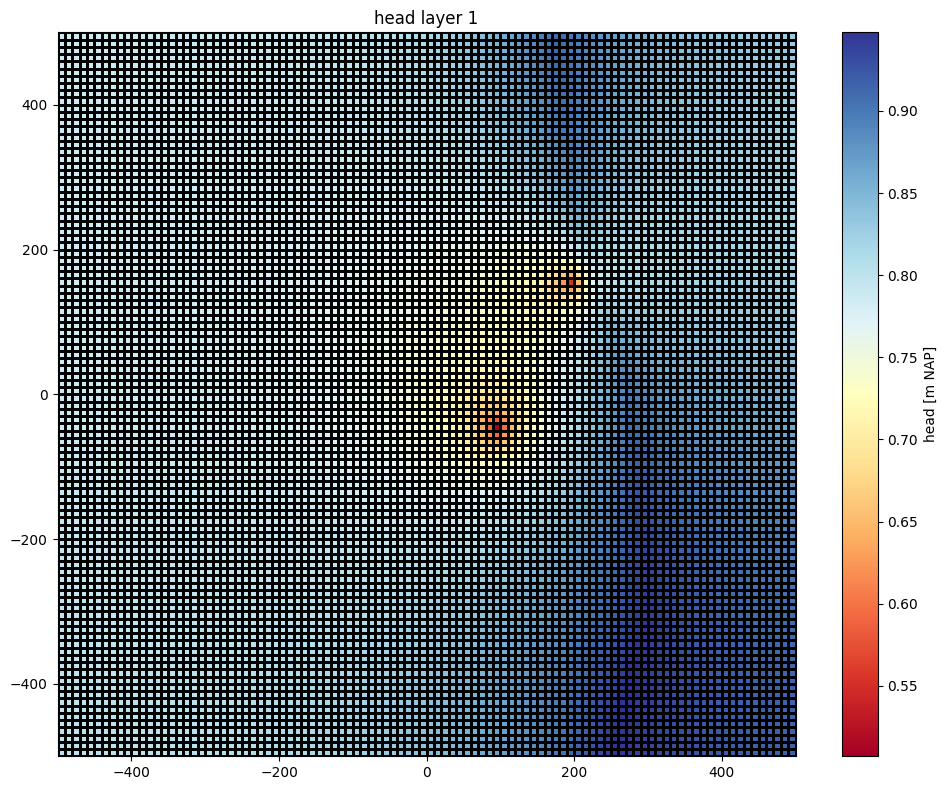

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

pc = nlmod.plot.data_array(
    ds['heads'].sel(layer=1).isel(time=0),
    ds=ds,
    cmap="RdYlBu",
    ax=ax,
    edgecolor="k",
)
ax.axis(extent)
cbar = ax.figure.colorbar(pc, shrink=1.0)
cbar.set_label("head [m NAP]")
ax.set_title("head layer 1")
fig.tight_layout()

## Exercises

#### Exercise 1

In the plot above the heads in model layer 1 are plotted. Make 2 other plots with:
1. The heads in model layer 2
2. The differences in heads between model layer 1 and 2

Please explain the differences in heads between these layers.

#### Exercise 2

We used the function `nlmod.gwf.get_heads_da` to obtain the modelled heads. Now use the function `nlmod.gwf.get_budget_da` to obatin the flux (budget) of the river package. This data shows how much water infiltrates from the river to the groundwater.
1. Plot the river budget of the first model layer. Explain what you see
2. Calculate the total infiltration from the river to the groundwater.
3. What other fluxes do you expect in this model? How big are they? Can you explain the differences in these fluxes?

#### Exercise 3

Add a constant recharge of 0.7 mm/day to the model using the recharge package. You can use this flopy function: `flopy.mf6.ModflowGwfrch`. Plot the heads and compare this with the previous heads. What differences do you see?

#### Exercise 4

By setting the `time` coordinates of the model dataset `ds` you can make the model transient. Modify the function `nlmod.time.set_ds_time` to create a transient model with 30 time steps of one day. Have a look at this example model to see how to set the transient time steps: https://nlmod.readthedocs.io/en/stable/examples/03_local_grid_refinement.html

After you've done that change the well extraction rate. Start with the extraction rates as before. After 5 days set the extraction rates to zero. Plot the groundwater head over at a distance of 20, 40 and 100 meters from both extraction wells.